In [1]:
import awkward as ak
import numpy as np
import uproot as uproot
import matplotlib.pyplot as plt
import mplhep as hep
import vector as vec
import matplotlib
from tqdm import tqdm
from numba import prange,njit
import math
plt.style.use(hep.style.CMS)
%matplotlib inline

In [2]:
@njit
def dist_numba(refEta, refPhi, otherTsEta, otherTsPhi):
    out = []
    for i in range(len(otherTsEta)):
        deltaphi=abs(otherTsPhi[i] - refPhi)
        if deltaphi>math.pi: deltaphi=deltaphi-2*math.pi
        distance = ((otherTsEta[i] - refEta) ** 2 + (deltaphi) ** 2) ** 0.5
        out.append(distance)
    return np.array(out)
@njit
def distWrap_numba(refEta, refPhi, otherTsEta, otherTsPhi):
    out = []
    for i in range(len(otherTsEta)):
        deltaPhi = otherTsPhi[i] - refPhi
        deltaPhi = (deltaPhi + np.pi) % (2 * np.pi) - np.pi
        distance = ((otherTsEta[i] - refEta) ** 2 + deltaPhi ** 2) ** 0.5
        out.append(distance)
    return np.array(out)

In [3]:
filename='/eos/cms/store/group/dpg_hgcal/comm_hgcal/wredjeb/TICLv5Performance/TimeResolutionPtError0PU/SinglePionTiming_1p9_100GeV/histo/histo_96692_2.root'
#filename = "/eos/cms/store/group/dpg_hgcal/comm_hgcal/wredjeb/TICLv5Performance/TimeResolutionFinal200PU/SinglePionTimingPU_1p9_50GeV/histo/histo_81848_2.root"
file = uproot.open(filename)

In [4]:
file.keys()

['ticlDumper;1',
 'ticlDumper/trackstersCLUE3DHigh;1',
 'ticlDumper/trackstersTiclCandidate;1',
 'ticlDumper/simtrackstersSC;1',
 'ticlDumper/simtrackstersCP;1',
 'ticlDumper/simtracksters2HitsSC;1',
 'ticlDumper/simtracksters2HitsCP;1',
 'ticlDumper/trackstersSuperclusteringDNN;1',
 'ticlDumper/candidates;1',
 'ticlDumper/associations;1',
 'ticlDumper/tracks;1',
 'ticlDumper/simTICLCandidate;1']

In [5]:

alltracksters = file['ticlDumper/trackstersCLUE3DHigh;1']
allsimtrackstersCP = file['ticlDumper/simtrackstersCP;1']
alltracks = file["ticlDumper/tracks;1"]
allassociations = file['ticlDumper/associations;1']
allsimcands=file["ticlDumper/simTICLCandidate;1"]

In [6]:
allsimtrackstersCP.keys()
allsimcands.keys()

['event',
 'event/run_',
 'event/luminosityBlock_',
 'event/event_',
 'simTICLCandidate_raw_energy',
 'simTICLCandidate_regressed_energy',
 'simTICLCandidate_simTracksterCPIndex',
 'simTICLCandidate_boundaryX',
 'simTICLCandidate_boundaryY',
 'simTICLCandidate_boundaryZ',
 'simTICLCandidate_boundaryPx',
 'simTICLCandidate_boundaryPy',
 'simTICLCandidate_boundaryPz',
 'simTICLCandidate_time',
 'simTICLCandidate_caloParticleMass',
 'simTICLCandidate_pdgId',
 'simTICLCandidate_charge',
 'simTICLCandidate_track_in_candidate']

In [7]:
alltracksters.keys()

['event',
 'event/run_',
 'event/luminosityBlock_',
 'event/event_',
 'NTracksters',
 'NClusters',
 'time',
 'timeError',
 'regressed_energy',
 'raw_energy',
 'raw_em_energy',
 'raw_pt',
 'raw_em_pt',
 'barycenter_x',
 'barycenter_y',
 'barycenter_z',
 'barycenter_eta',
 'barycenter_phi',
 'EV1',
 'EV2',
 'EV3',
 'eVector0_x',
 'eVector0_y',
 'eVector0_z',
 'sigmaPCA1',
 'sigmaPCA2',
 'sigmaPCA3',
 'id_probabilities',
 'vertices_indexes',
 'vertices_x',
 'vertices_y',
 'vertices_z',
 'vertices_time',
 'vertices_timeErr',
 'vertices_energy',
 'vertices_correctedEnergy',
 'vertices_correctedEnergyUncertainty',
 'vertices_multiplicity']

In [8]:
simtrackstersCP = allsimtrackstersCP.arrays([
 'regressed_energy',
 'raw_energy',
 'raw_em_energy',
 'raw_pt',
 'raw_em_pt',
 'barycenter_x',
 'barycenter_y',
 'barycenter_z',
 'barycenter_eta',
 'barycenter_phi',
 'EV1',
 'EV2',
 'EV3',
 'eVector0_x',
 'eVector0_y',
 'eVector0_z',
 'sigmaPCA1',
 'sigmaPCA2',
 'sigmaPCA3',
 'regressed_pt',
 'pdgID'])

In [9]:
tracksters = alltracksters.arrays([
 'regressed_energy',
 'raw_energy',
 'raw_em_energy',
 'raw_pt',
 'raw_em_pt',
 'barycenter_x',
 'barycenter_y',
 'barycenter_z',
 'barycenter_eta',
 'barycenter_phi',
 'EV1',
 'EV2',
 'EV3',
 'eVector0_x',
 'eVector0_y',
 'eVector0_z',
 'sigmaPCA1',
 'sigmaPCA2',
 'sigmaPCA3'])
print(tracksters[0]["regressed_energy"])

[117, 8.52, 13.8, 147, 5.86, 9.85, 4.07, ... 17.2, 4.18, 0, 5.29, 51.8, 0, 4.78]


In [21]:
allsimtrackstersCP.keys()
tsCP=allsimtrackstersCP.arrays(["trackIdx"])
tracks=alltracks.arrays(["track_pt","track_quality","track_missing_outer_hits"])
simcands=allsimcands.arrays(["simTICLCandidate_track_in_candidate"])
associations = allassociations.arrays(['tsCLUE3D_simToReco_CP',
 'tsCLUE3D_simToReco_CP_score',
 'tsCLUE3D_simToReco_CP_sharedE','tsCLUE3D_recoToSim_CP_sharedE',"tsCLUE3D_recoToSim_CP"])
trks=alltracks.arrays(["track_hgcal_eta","track_hgcal_phi","track_pt","track_id"])

#print(associations[0][])

#print(tsCP[0],tracks[0],simcands[0])

  0%|          | 0/1 [00:00<?, ?it/s]/tmp/ipykernel_492/1236847359.py:50: RuntimeWarning: invalid value encountered in double_scalars
  contamination=1. - np.sum(sharedEnergy_sorted[(distance_sorted<distScan[k]) & (assocIdxs_sorted==i) ])/np.sum(tsEnergy_sorted[distance_sorted<distScan[k]])


[0, 1]
2
[0, 1]


100%|██████████| 1/1 [00:00<00:00,  2.46it/s]


0.014285714285714285


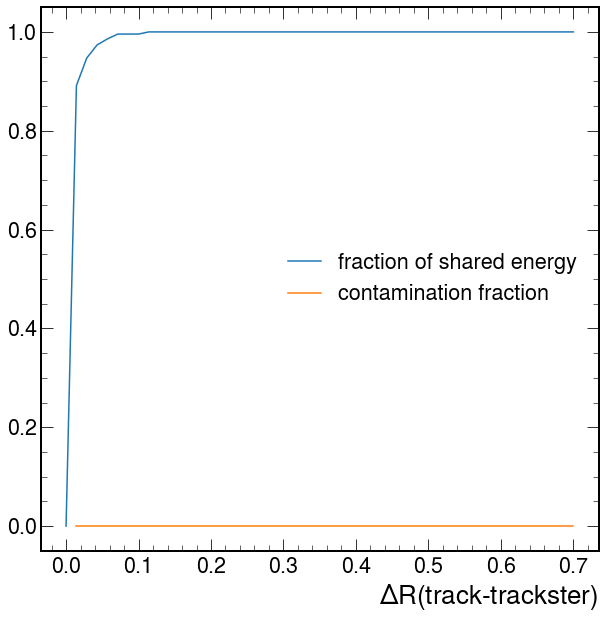

In [24]:
#EXAMPLE PLOT 

for ev in tqdm(range(1)):#len(tsCP))):
    assEv=associations[ev]
    print(trks[ev]["track_id"])
    print(len(trks[ev]["track_id"]))
    print(tsCP[ev]["trackIdx"])
    for i in range(len(tsCP[ev]["trackIdx"])):
        #print(len((tsCP[ev]["trackIdx"])))
        if tsCP[ev]["trackIdx"][i]==-1: continue
        #print(tsCP[ev]["trackIdx"][i], np.where(trks[ev]["track_id"]==tsCP[ev]["trackIdx"][i]), len(trks[ev]["track_id"]))#, trks[ev]["track_id"][np.where(trks[ev]["track_id"]==tsCP[ev]["trackIdx"][i])[0][0]])
        try:
            trackIdx=np.where(trks[ev]["track_id"]==tsCP[ev]["trackIdx"][i])[0][0]
        except ValueError:
            continue
        #trackIdx=tsCP[ev]["trackIdx"][i]
        
        #print(len(trks[ev]["track_hgcal_eta"]),trackIdx)
        #print(trks[ev]["track_hgcal_eta"][trackIdx])
        refEta=trks[ev]["track_hgcal_eta"][trackIdx]
        refPhi=trks[ev]["track_hgcal_phi"][trackIdx]
        tsEv = tracksters[ev]
        otherTsEta = tsEv["barycenter_eta"]
        otherTsPhi = tsEv["barycenter_phi"]
        #distance = ((otherTsEta-refEta)**2 + (otherTsPhi-refPhi)**2)**0.5
        #print(otherTsPhi)
        #print(distance)
        distance = distWrap_numba(refEta, refPhi, otherTsEta, otherTsPhi)
        #print(distance)
        
        idx_sort = np.array(distance).argsort()
        distance_sorted = distance[idx_sort]
        #print (distance_sorted)
        tsEnergy_sorted = tsEv.raw_energy[idx_sort]
        sharedEnergy_sorted = assEv["tsCLUE3D_recoToSim_CP_sharedE"][idx_sort]
        assocIdxs_sorted = assEv["tsCLUE3D_recoToSim_CP"][idx_sort]
        #print(assEv["tsCLUE3D_recoToSim_CP_sharedE"][0])
        #print(assEv["tsCLUE3D_recoToSim_CP"][0])
        #print(len(assEv["tsCLUE3D_simToReco_CP_sharedE"]))
        #print(len(assEv.tsCLUE3D_recoToSim_CP_sharedE), len(idx_sort), len(tsEv["barycenter_eta"]))
        totalSharedE=np.sum(sharedEnergy_sorted[assocIdxs_sorted==i])
        #print(totalSharedE)
        distScan=np.linspace(0,0.7,50)
        listE=[]
        listContamination=[]
        radius=-1
        for k in range(len(distScan)):
            tempEn=np.sum(sharedEnergy_sorted[(distance_sorted<distScan[k]) & (assocIdxs_sorted==i) ])
            frac=tempEn/totalSharedE
            contamination=1. - np.sum(sharedEnergy_sorted[(distance_sorted<distScan[k]) & (assocIdxs_sorted==i) ])/np.sum(tsEnergy_sorted[distance_sorted<distScan[k]])
            
            if (frac>0.8 and radius==-1):
                radius=distScan[k]
            listE.append(tempEn/totalSharedE)
            listContamination.append(contamination)
            
        
plt.plot(distScan,listE,label="fraction of shared energy")
plt.plot(distScan,listContamination,label="contamination fraction")
plt.xlabel("$\Delta R$(track-trackster)")
plt.legend()
plt.savefig("example.png")
print(radius)
        


In [12]:
#ON ALL EVENTS
CUT=0.8
dict_info={"R" : [],
           "eta_trk" : [],
           "phi_trk" : [],
           "pt_trk" : [],
           "contamination" : []
          }

for ev in tqdm(range(len(tsCP))):
    assEv=associations[ev]
    for i in tqdm(range(len(tsCP[ev]["trackIdx"]))):
        if tsCP[ev]["trackIdx"][i]==-1: continue
        try:
            trackIdx=np.where(trks[ev]["track_id"]==tsCP[ev]["trackIdx"][i])[0][0]
        except ValueError:
            continue
        
        refEta=trks[ev]["track_hgcal_eta"][trackIdx]
        refPhi=trks[ev]["track_hgcal_phi"][trackIdx]
        tsEv = tracksters[ev]
        otherTsEta = tsEv["barycenter_eta"]
        otherTsPhi = tsEv["barycenter_phi"]
        #distance = ((otherTsEta-refEta)**2 + (otherTsPhi-refPhi)**2)**0.5
        #print(distance)
        distance = distWrap_numba(refEta, refPhi, otherTsEta, otherTsPhi)
        #print(distance)
        
        idx_sort = np.array(distance).argsort()
        distance_sorted = distance[idx_sort]
        tsEnergy_sorted = tsEv.raw_energy[idx_sort]
        sharedEnergy_sorted = assEv["tsCLUE3D_recoToSim_CP_sharedE"][idx_sort]
        assocIdxs_sorted = assEv["tsCLUE3D_recoToSim_CP"][idx_sort]
        correctTrackMask=assocIdxs_sorted==i
        totalSharedE=np.sum(sharedEnergy_sorted[correctTrackMask])
        distScan=np.linspace(0,0.7,100)
        listE=[]
        listContamination=[]
        radius=-1
        for k in range(len(distScan)):
            tempEn=np.sum(sharedEnergy_sorted[(distance_sorted<distScan[k]) & (correctTrackMask) ])
            frac=tempEn/totalSharedE
            try:
                contamination=1. - np.sum(sharedEnergy_sorted[(distance_sorted<distScan[k]) & (assocIdxs_sorted==i) ])/np.sum(tsEnergy_sorted[distance_sorted<distScan[k]])
            except ZeroDivisionError:
                contamination=0
            
            if (frac>CUT and radius==-1):
                radius=distScan[k] 
                break
            #listE.append(tempEn/totalSharedE)
            #listContamination.append(contamination)
        if radius!=-1:
            dict_info["R"].append(radius)
            dict_info["eta_trk"].append(abs(trks[ev]["track_hgcal_eta"][trackIdx]))
            dict_info["phi_trk"].append(trks[ev]["track_hgcal_phi"][trackIdx])
            dict_info["pt_trk"].append(trks[ev]["track_pt"][trackIdx])
            dict_info["contamination"].append(contamination)
            
            
            
        
#plt.plot(distScan,listE,label="fraction of shared energy")
#plt.plot(distScan,listContamination,label="contamination fraction")
#plt.xlabel("$\Delta R$(track-trackster)")
#plt.legend()
#print(radius)

  0%|          | 0/2 [00:00<?, ?it/s]/tmp/ipykernel_492/3016883403.py:44: RuntimeWarning: invalid value encountered in double_scalars
  contamination=1. - np.sum(sharedEnergy_sorted[(distance_sorted<distScan[k]) & (assocIdxs_sorted==i) ])/np.sum(tsEnergy_sorted[distance_sorted<distScan[k]])
100%|██████████| 2/2 [00:00<00:00, 77.75it/s]

100%|██████████| 2/2 [00:00<00:00, 35.88it/s]

100%|██████████| 2/2 [00:00<00:00, 65.39it/s]

100%|██████████| 2/2 [00:00<00:00, 85.02it/s]

100%|██████████| 2/2 [00:00<00:00, 93.77it/s]

100%|██████████| 2/2 [00:00<00:00, 92.96it/s]

100%|██████████| 2/2 [00:00<00:00, 97.51it/s]

100%|██████████| 2/2 [00:00<00:00, 50.84it/s]

100%|██████████| 2/2 [00:00<00:00, 93.91it/s]

100%|██████████| 2/2 [00:00<00:00, 93.39it/s]

100%|██████████| 2/2 [00:00<00:00, 75.26it/s]

100%|██████████| 2/2 [00:00<00:00,  9.09it/s]

100%|██████████| 2/2 [00:00<00:00, 160.67it/s]

100%|██████████| 2/2 [00:00<00:00, 119.49it/s]

100%|██████████| 2/2 [00:00<00:00, 72.15it/s]

1

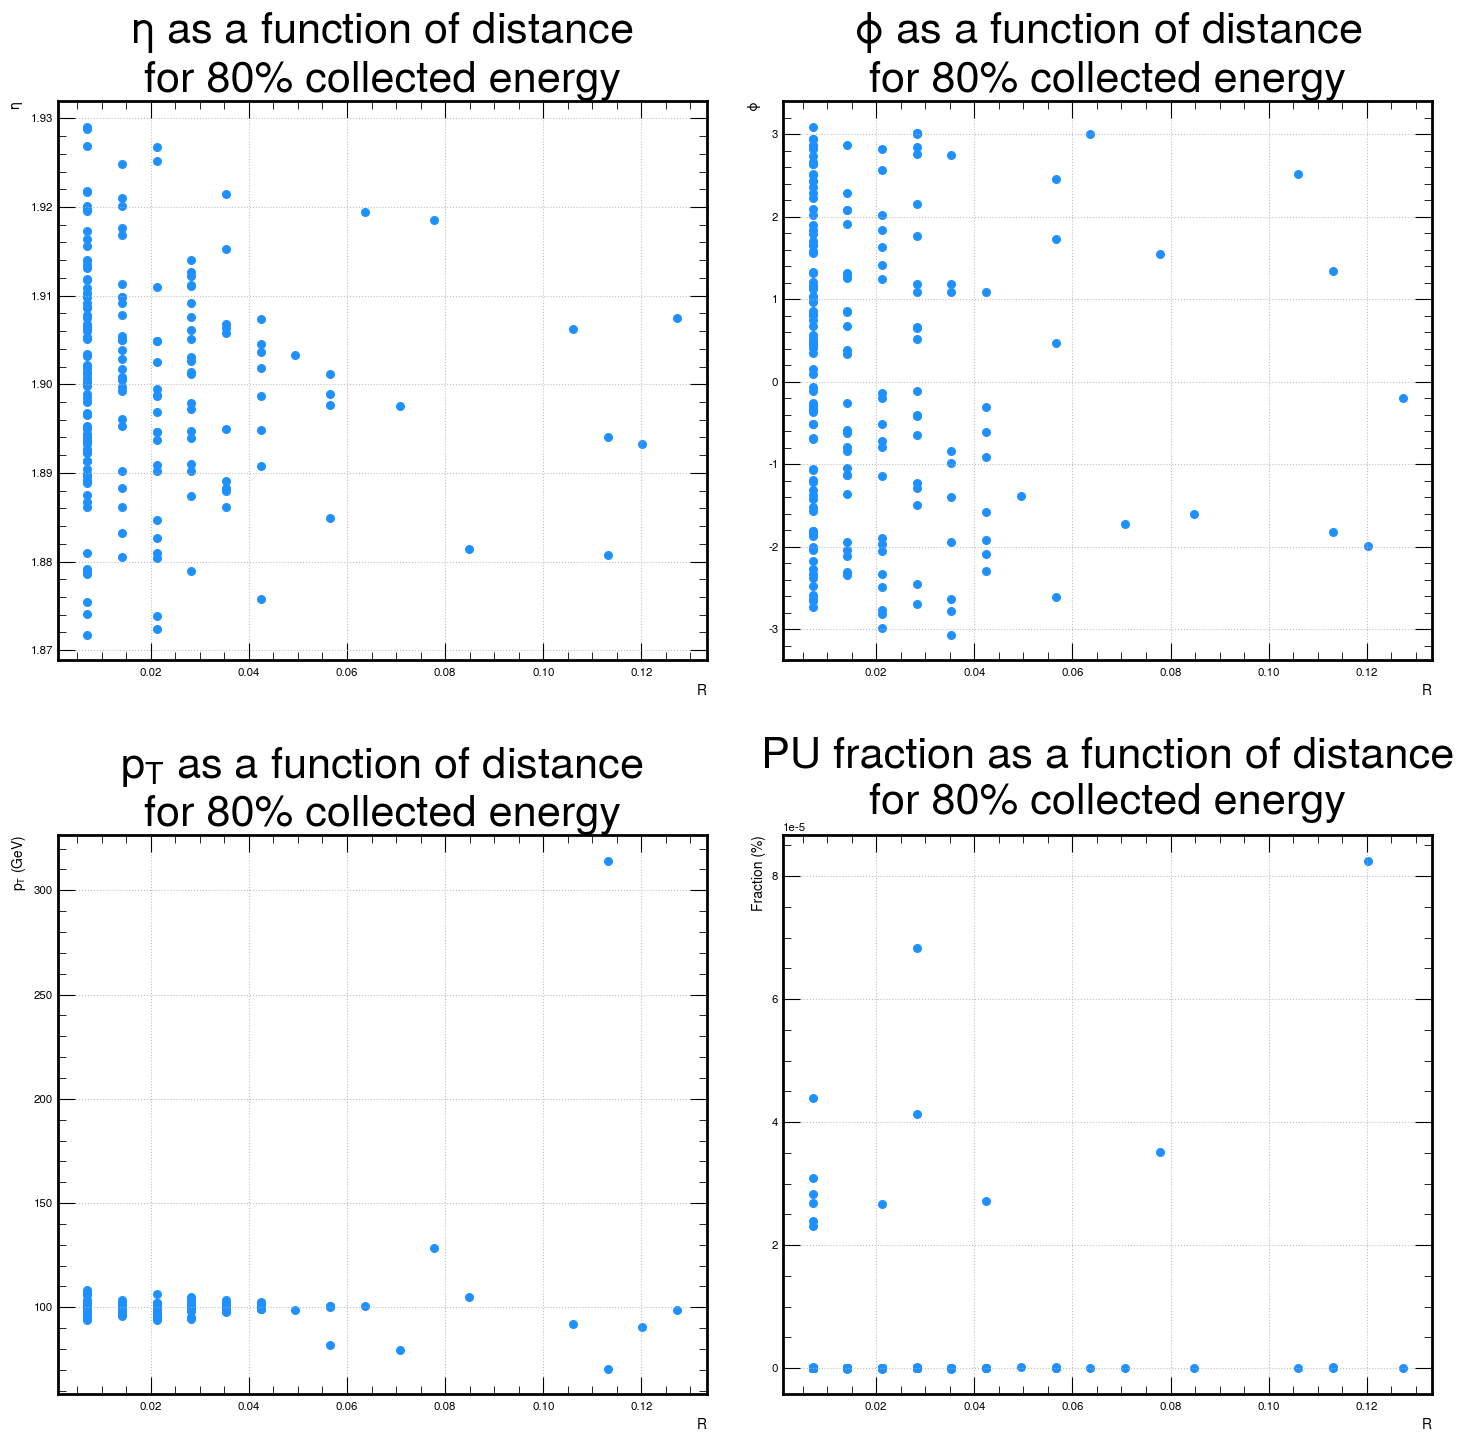

In [13]:
def scatterAx(plt, X, Y, s=10, title='title', xlabel='time (ns)', ylabel='z (cm)'):
    try:
        plt.scatter(ak.flatten(X), ak.flatten(Y), s=ak.flatten(s), color='dodgerblue')
    except:
        plt.scatter(X, Y, s=s, color='dodgerblue')
    plt.set_title(title)
    plt.set_xlabel(xlabel)
    plt.set_ylabel(ylabel)
    plt.grid()

fig, axs = plt.subplots(2, 2, figsize=(15,15), dpi=100)
plt.style.use(hep.style.CMS)

# Flatten the 2x2 grid into a list to easily access each subplot
axs = axs.flatten()

# Plot each scatter plot on its corresponding axis
scatterAx(axs[0], dict_info["R"], (dict_info["eta_trk"]), s=30, title=f'$\eta$ as a function of distance\nfor {CUT*100:.0f}% collected energy', xlabel="R", ylabel=f'$\eta$')
scatterAx(axs[1], dict_info["R"], dict_info["phi_trk"],      s=30, title=f'$\phi$ as a function of distance\nfor {CUT*100:.0f}% collected energy', xlabel="R", ylabel=f'$\phi$')
scatterAx(axs[2], dict_info["R"], dict_info["pt_trk"],      s=30, title=f'$p_T$ as a function of distance\nfor {CUT*100:.0f}% collected energy', xlabel="R", ylabel='$p_T$ (GeV)')
scatterAx(axs[3], dict_info["R"], dict_info["contamination"],      s=30, title=f'PU fraction as a function of distance\nfor {CUT*100:.0f}% collected energy', xlabel="R", ylabel='Fraction (%)')

plt.tight_layout()  # Automatically adjust subplot parameters to give specified padding
plt.show()

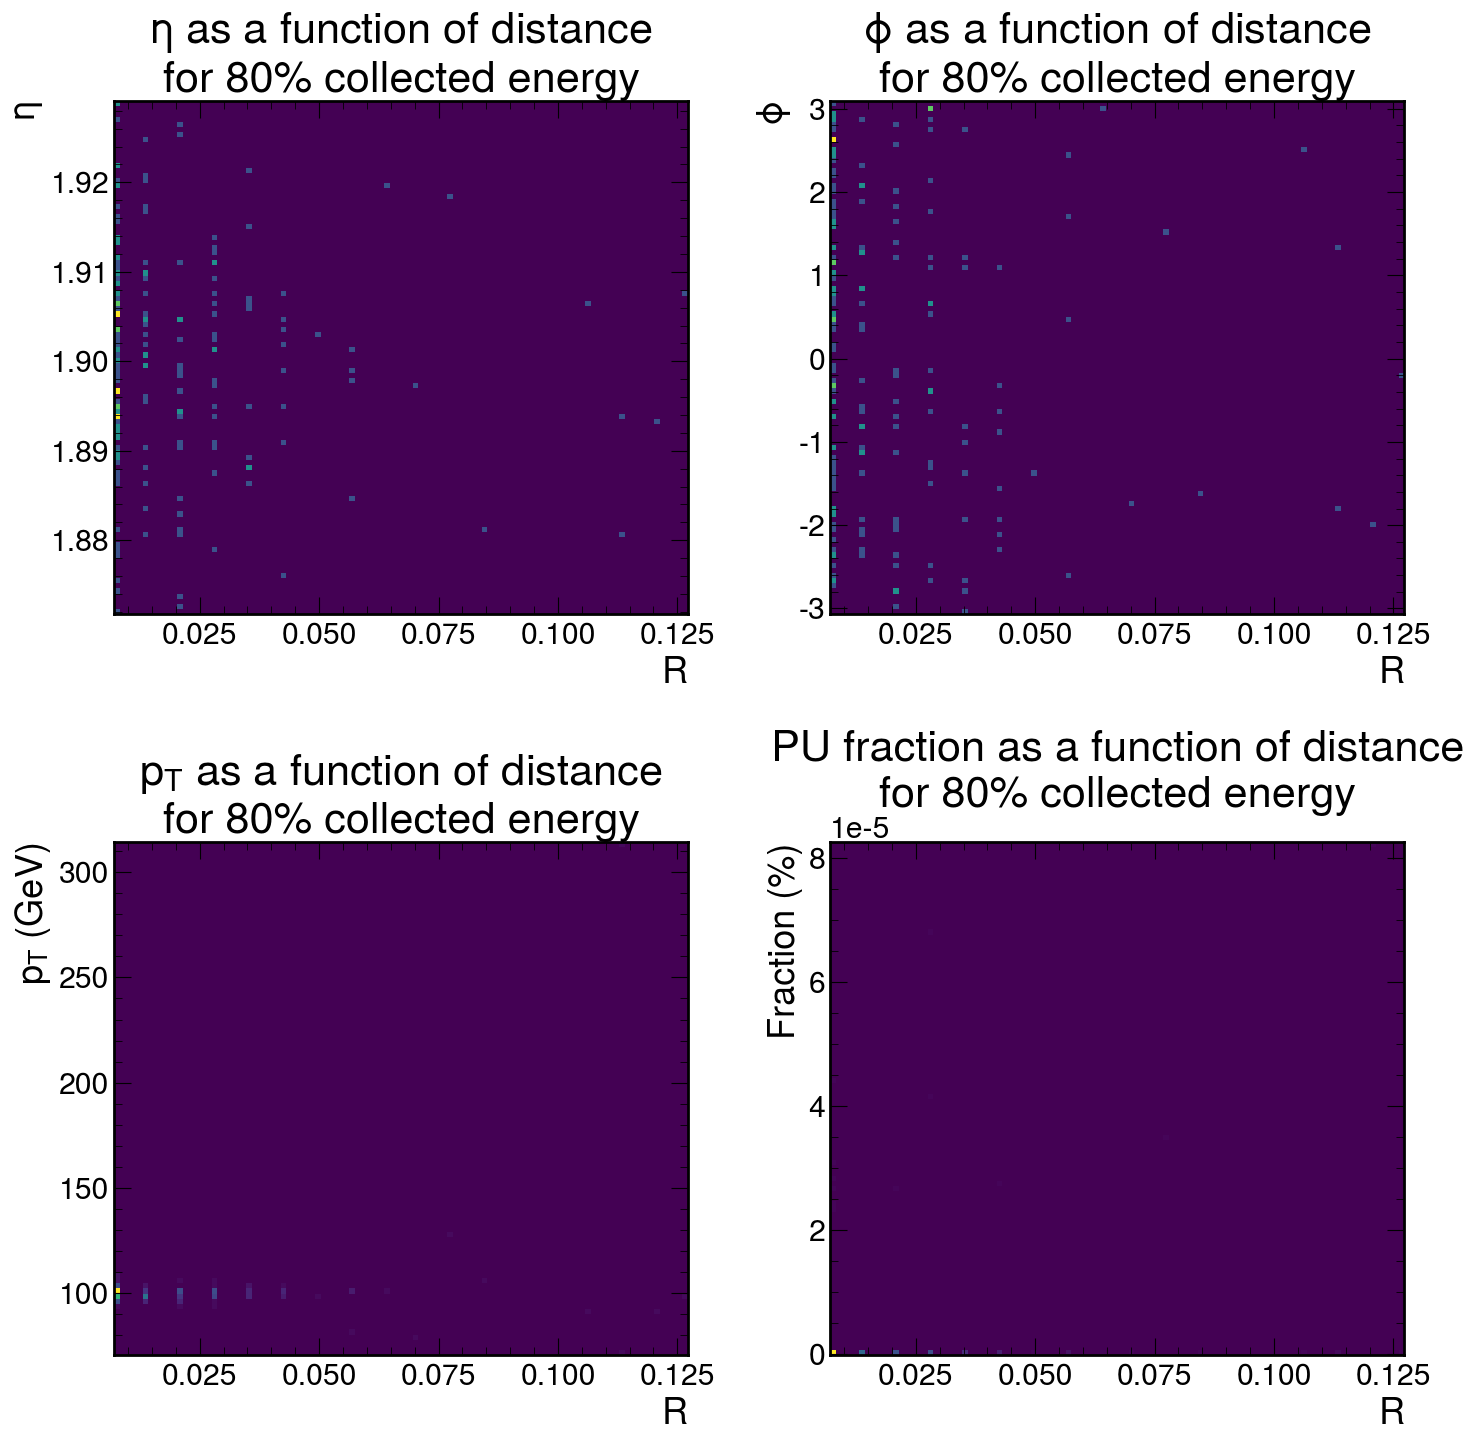

In [14]:
def hist2D_Ax(plt, X, Y, s=10, title='title', xlabel='time (ns)', ylabel='z (cm)'):
    try:
        plt.hist2d(ak.flatten(X), ak.flatten(Y),bins=50)#, s=ak.flatten(s), color='dodgerblue')
    except:
        plt.hist2d(X, Y,bins=100)#, s=s, color='dodgerblue')
    plt.set_title(title)
    plt.set_xlabel(xlabel)
    plt.set_ylabel(ylabel)
    #plt.grid()

fig, axs = plt.subplots(2, 2, figsize=(15,15), dpi=100)
plt.style.use(hep.style.CMS)

# Flatten the 2x2 grid into a list to easily access each subplot
axs = axs.flatten()

# Plot each scatter plot on its corresponding axis
hist2D_Ax(axs[0], dict_info["R"], (dict_info["eta_trk"]), s=30, title=f'$\eta$ as a function of distance\nfor {CUT*100:.0f}% collected energy', xlabel="R", ylabel=f'$\eta$')
hist2D_Ax(axs[1], dict_info["R"], dict_info["phi_trk"],      s=30, title=f'$\phi$ as a function of distance\nfor {CUT*100:.0f}% collected energy', xlabel="R", ylabel=f'$\phi$')
hist2D_Ax(axs[2], dict_info["R"], dict_info["pt_trk"],      s=30, title=f'$p_T$ as a function of distance\nfor {CUT*100:.0f}% collected energy', xlabel="R", ylabel='$p_T$ (GeV)')
hist2D_Ax(axs[3], dict_info["R"], dict_info["contamination"],      s=30, title=f'PU fraction as a function of distance\nfor {CUT*100:.0f}% collected energy', xlabel="R", ylabel='Fraction (%)')

plt.tight_layout()  # Automatically adjust subplot parameters to give specified padding
plt.show()

In [15]:
alltracksters.keys()

['event',
 'event/run_',
 'event/luminosityBlock_',
 'event/event_',
 'NTracksters',
 'NClusters',
 'time',
 'timeError',
 'regressed_energy',
 'raw_energy',
 'raw_em_energy',
 'raw_pt',
 'raw_em_pt',
 'barycenter_x',
 'barycenter_y',
 'barycenter_z',
 'barycenter_eta',
 'barycenter_phi',
 'EV1',
 'EV2',
 'EV3',
 'eVector0_x',
 'eVector0_y',
 'eVector0_z',
 'sigmaPCA1',
 'sigmaPCA2',
 'sigmaPCA3',
 'id_probabilities',
 'vertices_indexes',
 'vertices_x',
 'vertices_y',
 'vertices_z',
 'vertices_time',
 'vertices_timeErr',
 'vertices_energy',
 'vertices_correctedEnergy',
 'vertices_correctedEnergyUncertainty',
 'vertices_multiplicity']

In [16]:
alltracks.keys()

['event',
 'event/run_',
 'event/luminosityBlock_',
 'event/event_',
 'track_id',
 'track_hgcal_x',
 'track_hgcal_y',
 'track_hgcal_z',
 'track_hgcal_eta',
 'track_hgcal_phi',
 'track_hgcal_pt',
 'track_pt',
 'track_ptErr',
 'track_missing_outer_hits',
 'track_missing_inner_hits',
 'track_quality',
 'track_charge',
 'track_time',
 'track_time_quality',
 'track_time_err',
 'track_beta',
 'track_time_mtd',
 'track_time_mtd_err',
 'track_pos_mtd',
 'track_pos_mtd/track_pos_mtd.theVector.theX',
 'track_pos_mtd/track_pos_mtd.theVector.theY',
 'track_pos_mtd/track_pos_mtd.theVector.theZ',
 'track_nhits',
 'track_isMuon',
 'track_isTrackerMuon']

In [17]:
allassociations.keys()

['event',
 'event/run_',
 'event/luminosityBlock_',
 'event/event_',
 'tsCLUE3D_recoToSim_SC',
 'tsCLUE3D_recoToSim_SC_score',
 'tsCLUE3D_recoToSim_SC_sharedE',
 'tsCLUE3D_simToReco_SC',
 'tsCLUE3D_simToReco_SC_score',
 'tsCLUE3D_simToReco_SC_sharedE',
 'tsCLUE3D_recoToSim_CP',
 'tsCLUE3D_recoToSim_CP_score',
 'tsCLUE3D_recoToSim_CP_sharedE',
 'tsCLUE3D_simToReco_CP',
 'tsCLUE3D_simToReco_CP_score',
 'tsCLUE3D_simToReco_CP_sharedE',
 'ticlCandidate_recoToSim_CP',
 'ticlCandidate_recoToSim_CP_score',
 'ticlCandidate_recoToSim_CP_sharedE',
 'ticlCandidate_simToReco_CP',
 'ticlCandidate_simToReco_CP_score',
 'ticlCandidate_simToReco_CP_sharedE',
 'ticlCandidate_recoToSim_SC',
 'ticlCandidate_recoToSim_SC_score',
 'ticlCandidate_recoToSim_SC_sharedE',
 'ticlCandidate_simToReco_SC',
 'ticlCandidate_simToReco_SC_score',
 'ticlCandidate_simToReco_SC_sharedE',
 'tsCLUE3D_recoToSim_SC2Hits',
 'tsCLUE3D_recoToSim_SC2Hits_score',
 'tsCLUE3D_recoToSim_SC2Hits_sharedE',
 'tsCLUE3D_simToReco_SC2Hits

In [18]:
associations = allassociations.arrays(['tsCLUE3D_simToReco_CP',
 'tsCLUE3D_simToReco_CP_score',
 'tsCLUE3D_simToReco_CP_sharedE'])


In [19]:
# for i in prange(len(dumperInput.inputReaders)):
#     dumper = dumperInput.inputReaders[i].ticlDumperReader
#     cands = dumper.candidates
#     simCands = dumper.simCandidates
#     ass = dumper.associations
#     sims = dumper.simTrackstersCP
#     tracks = dumper.tracks

#for ev in range(len())
#trk=alltracks["track_hgcal_phi"]


MAX=0.999
for ev in prange(len(tracksters)):
    trkEtaEv=trks[ev]["track_hgcal_eta"]
    trkPhiEv=trks[ev]["track_hgcal_phi"]
    #tracksev=tracks[ev]
    tsEv = tracksters[ev]
    stsEv = simtrackstersCP[ev]
    assEv = associations[ev]
    
    
    for idxtrk in range(len(trkEtaEv)):
        refEta=trkEtaEv[idxtrk]
        refPhi=trkPhiEv[idxtrk]
        otherTsEta = tsEv.barycenter_eta
        otherTsPhi = tsEv.barycenter_phi
        ##distance = ((otherTsEta-refEta)**2 + (otherTsPhi-refPhi)**2)**0.5
        #print(distance)
        distance = distWrap_numba(refEta, refPhi, otherTsEta, otherTsPhi)
        #print(distance)
        
        idx_sort = np.array(distance).argsort()
        distance_sorted = distance[idx_sort]
        tsEnergy_sorted = tsEv.raw_energy[idx_sort]
        #print(distance_sorted)

    """
    print("Event:", ev)
    for stId, simEnergy in enumerate(stsEv.raw_energy):
        score = assEv.tsCLUE3D_simToReco_CP_score[stId]
        simToReco = assEv.tsCLUE3D_simToReco_CP[stId][score<MAX]
        sharedE = assEv.tsCLUE3D_simToReco_CP_sharedE[stId][score<MAX]
        score = score[score<MAX]

        # trackster with the higher shared energy
        refId = simToReco[np.argmax(sharedE)]
        refEta = tsEv.barycenter_eta[refId]
        refPhi = tsEv.barycenter_phi[refId]

        # sort the others by distance in eta-phi
        otherTsEta = tsEv.barycenter_eta
        otherTsPhi = tsEv.barycenter_phi
        distance = ((otherTsEta-refEta)**2 + (otherTsPhi-refPhi)**2)**0.5
        idx_sort = np.array(distance).argsort()
        tsEnergy_sorted=tsEv.raw_energy[idx_sort]

        print(refId, refEta, refPhi, "\n",sorted(distance), distance[idx_sort],tsEnergy_sorted)
        distances=np.linspace(0,1,100)
    """
